In [67]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz


In [3]:
data = pd.read_csv('/Users/kexinluo/Desktop/DS_take_home/3.Employee_rentation/Employee_Rentation.csv', parse_dates=['join_date', 'quit_date'],index_col=0)
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
1,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
2,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
3,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
4,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
5,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24702 entries, 1 to 24702
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24702 non-null  float64       
 1   company_id   24702 non-null  int64         
 2   dept         24702 non-null  object        
 3   seniority    24702 non-null  int64         
 4   salary       24702 non-null  float64       
 5   join_date    24702 non-null  datetime64[ns]
 6   quit_date    13510 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.5+ MB


In [5]:
data.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


Max seniority = 99 must be wrong

# Create Table for day, employee_headcount, and company_id

In [6]:
# Define useful information
unique_date = pd.date_range(start='2011-01-24', end='2015-12-13', freq='D')
unique_company = sorted(data['company_id'].unique())

day = []
company = []
headcount = []

# Loop through date and company id
for date in unique_date:
    for idx in unique_company:
        total_join = len(data[(data['join_date'] <= date) & (data['company_id'] == idx)])
        total_quit = len(data[(data['quit_date'] <= date) & (data['company_id'] == idx)])
        day.append(date)
        company.append(idx)
        headcount.append(total_join - total_quit)

# Create table for day, employee_headcount, company_id
table = pd.DataFrame({'day': day, 'company_id': company, 'employee_headcount': headcount}, 
                     columns=['day', 'company_id', 'employee_headcount'])

In [7]:
table.head()

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


# Employee Churn Analysis

In [16]:
# Separate stay and quit data
quit_data = data[~data['quit_date'].isnull()]
stay_data = data[data['quit_date'].isnull()]

In [19]:
print(f"Number of people quit: {quit_data.shape[0]}")
print(f"Number of people don't quit: {stay_data.shape[0]}")

Number of people quit: 13510
Number of people don't quit: 11192


## Feature Engineering

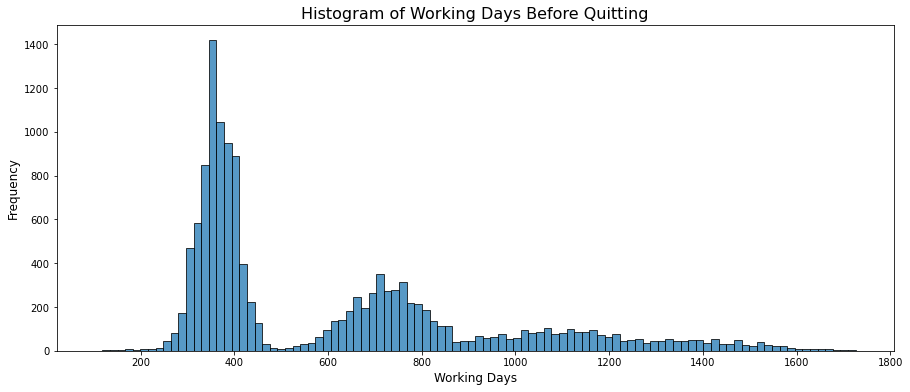

In [11]:
# Total working days
work_days = np.array(list(map(lambda x: x.days, quit_data['quit_date'] - quit_data['join_date'])))

fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(work_days, bins=100, kde=False, ax=ax)
ax.set_title('Histogram of Working Days Before Quitting', fontsize=16)
ax.set_xlabel('Working Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

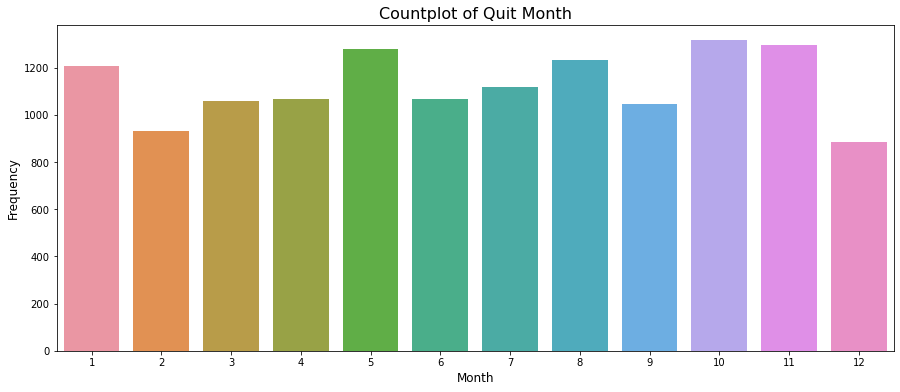

In [12]:
# Month No. for quiting
quit_week = np.array(list(map(lambda x: x.month, quit_data['quit_date'])))

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(quit_week, ax=ax)
ax.set_title('Countplot of Quit Month', fontsize=16)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

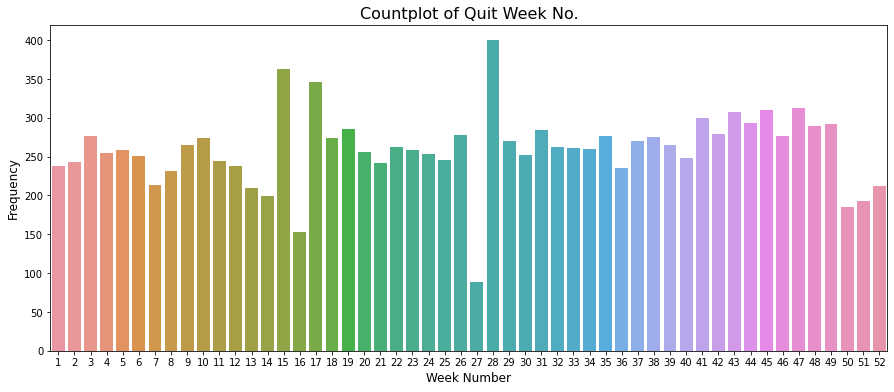

In [13]:
# Week No. for quiting
quit_week = np.array(list(map(lambda x: x.week, quit_data['quit_date'])))

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(quit_week, ax=ax)
ax.set_title('Countplot of Quit Week No.', fontsize=16)
ax.set_xlabel('Week Number', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

In [17]:
# add employment length and week as feature 
quit_data['employment_days'] = work_days
quit_data['quit_week'] = quit_week

quit_data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_days,quit_week
1,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,44
2,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340,14
4,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389,23
5,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040,34
6,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578,35


in the histogram of Working Days Before Quitting, it is clear that many people quit at about 500 days. The people that quit early may have different reasons compared to people who work longer 

# Decision Tree Model

In [32]:
stop_date = pd.to_datetime('2015-12-13') - pd.DateOffset(days=500)
subset0 = data[data['join_date'] < stop_date]

In [33]:
subset1 = data.loc[(data["join_date"] >= stop_date) & (data["quit_date"].notnull())]
subset1
# subset1 are valid early quiters 

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
46,537932.0,1,customer_service,7,89000.0,2014-08-18,2015-08-13
63,41164.0,1,customer_service,28,133000.0,2014-09-02,2015-09-04
64,779068.0,2,sales,25,166000.0,2014-11-24,2015-10-30
125,120280.0,1,data_science,22,303000.0,2014-11-03,2015-10-23
199,839686.0,8,customer_service,29,98000.0,2014-09-08,2015-07-31
...,...,...,...,...,...,...,...
24423,481754.0,3,design,16,151000.0,2014-09-29,2015-09-11
24453,779313.0,8,customer_service,24,100000.0,2014-08-25,2015-08-21
24593,196351.0,3,engineer,8,162000.0,2014-12-01,2015-11-25
24603,31903.0,10,customer_service,19,88000.0,2014-09-22,2015-10-02


In [51]:
subset = pd.concat([subset0, subset1], axis=0)

In [52]:
# Binary label for early quiters (less than 500 days)
quit0 = subset['quit_date'].isnull() | (subset['quit_date'] > subset['join_date'] + pd.DateOffset(days=500))
subset['quit'] = 1 - quit0.astype(int)

subset.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit
1,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
2,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
4,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1
5,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0
6,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,0


In [53]:
print(f"Number of samples in the subset: {subset.shape[0]}")
print(f"Proportion of early quiters in the subset: {np.mean(subset['quit'] == 1)}")

Number of samples in the subset: 18544
Proportion of early quiters in the subset: 0.39592320966350303


In [54]:
subset[subset['seniority'] > 40]
# probably wrong, change to mean seniority

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit
24701,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,0
24702,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06,0


In [55]:
subset.loc[subset['seniority'] > 90, 'seniority'] = np.nan
subset[subset['seniority'] > 40]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit


In [56]:
subset["seniority"].fillna(int(np.mean(subset['seniority'])), inplace = True)

In [57]:
one_hot = OneHotEncoder()
encoded = one_hot.fit_transform(subset[['dept']])
subset[one_hot.categories_[0]] = encoded.toarray()

subset.drop(['dept'], axis=1, inplace=True)

subset.head()

,employee_id,company_id,seniority,salary,join_date,quit_date,quit,customer_service,data_science,design,engineer,marketing,sales
1,13021.0,7,28.0,89000.0,2014-03-24,2015-10-30,0,1.0,0.0,0.0,0.0,0.0,0.0
2,825355.0,7,20.0,183000.0,2013-04-29,2014-04-04,1,0.0,0.0,0.0,0.0,1.0,0.0
4,662910.0,7,20.0,115000.0,2012-05-14,2013-06-07,1,1.0,0.0,0.0,0.0,0.0,0.0
5,256971.0,2,23.0,276000.0,2011-10-17,2014-08-22,0,0.0,1.0,0.0,0.0,0.0,0.0
6,509529.0,4,14.0,165000.0,2012-01-30,2013-08-30,0,0.0,1.0,0.0,0.0,0.0,0.0


In [58]:
subset['company_id'] = subset['company_id'].astype(str)

In [62]:
y = subset["quit"]
X = subset.drop(columns=["quit",'employee_id','join_date','quit_date'])
X.head()

,company_id,seniority,salary,customer_service,data_science,design,engineer,marketing,sales
1,7,28.0,89000.0,1.0,0.0,0.0,0.0,0.0,0.0
2,7,20.0,183000.0,0.0,0.0,0.0,0.0,1.0,0.0
4,7,20.0,115000.0,1.0,0.0,0.0,0.0,0.0,0.0
5,2,23.0,276000.0,0.0,1.0,0.0,0.0,0.0,0.0
6,4,14.0,165000.0,0.0,1.0,0.0,0.0,0.0,0.0


In [63]:
# Build decision tree
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
clf = clf.fit(X=X, y=y)

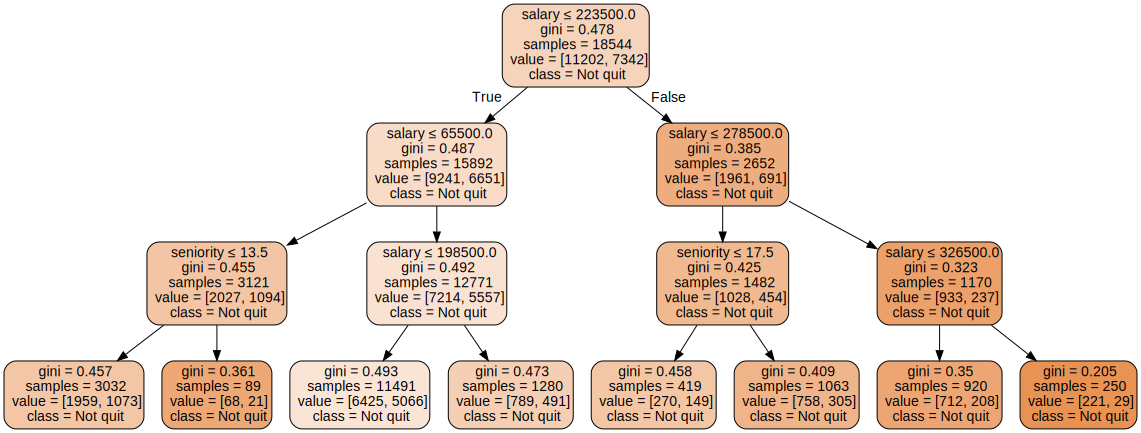

In [70]:
# Visualization
features = list(X.columns)
targets = ['Not quit', 'Quit']
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=features, class_names=targets, 
                                filled=True, rounded=True, special_characters=True, )  
graph = graphviz.Source(dot_data)
graph

In [71]:
# Feature importance
importance = sorted(zip(features, clf.feature_importances_), key=lambda x:x[1], reverse=True)
for feature, val in importance:
    print('{0:10s} | {1:.5f}'.format(feature, val))

salary     | 0.97104
seniority  | 0.02896
company_id | 0.00000
customer_service | 0.00000
data_science | 0.00000
design     | 0.00000
engineer   | 0.00000
marketing  | 0.00000
sales      | 0.00000
